In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
import torch
plt.style.use("ggplot")

## Data Visualization

In [31]:
# display the content of the chest_xray folder
os.listdir(path="./chest_xray/")

['chest_xray', 'test', 'train', 'val', '__MACOSX']

In [32]:
# general paths of the x-rays data
TRAIN_DIR = "./chest_xray/train/"
VALIDATION_DIR = "./chest_xray/val/"
TEST_DIR = "./chest_xray/test/"

In [60]:
"""All functions will be written in this block"""
def get_number_of_images(path_to_folder:str):
    normal = len(os.listdir(path_to_folder + "NORMAL"))
    pneumonia = len(os.listdir(path_to_folder + "PNEUMONIA"))
    total = normal + pneumonia

    return normal, pneumonia, total

def display_number_samples(set:str, normal:int, pneumonia:int)->None:
    table_data = [
        ["NORMAL", normal],
        ["PNEUMONIA", pneumonia],
        ["TOTAL", normal + pneumonia]
    ]
    
    print(f"{set} set:\n")
    print(tabulate(table_data, headers=["Class", "Number of Samples"], tablefmt="pretty"))
    print("\n")

def plot_normal_pneumonia(normal, pneumonia, subset="whole", ax=None) -> None:
    categories = ["Normal", "Pneumonia"]
    counts = [normal, pneumonia]

    # Creating a bar plot using Seaborn
    sns.barplot(x=categories, y=counts, ax=ax)

    # Adding labels and title to the plot
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title(f'Distribution of Images in the {subset} Set')

    # Displaying the number of instances on the bars
    for i, count in enumerate(counts):
        plt.text(i, count + 10, str(count), ha='center', va='bottom', weight="bold")

    # Displaying the plot
    plt.show()


In [61]:
os.listdir(TRAIN_DIR)

['NORMAL', 'PNEUMONIA']

In [62]:
normal_train, pneumonia_train, total_train = get_number_of_images(path_to_folder=TRAIN_DIR)
normal_val, pneumonia_val, total_val = get_number_of_images(path_to_folder=VALIDATION_DIR)
normal_test, pneumonia_test, total_test = get_number_of_images(path_to_folder=TEST_DIR)

In [63]:
display_number_samples(set="TRAIN", normal=normal_train, pneumonia=pneumonia_train)
display_number_samples(set="VALIDATION", normal=normal_val, pneumonia=pneumonia_val)

TRAIN set:

+-----------+-------------------+
|   Class   | Number of Samples |
+-----------+-------------------+
|  NORMAL   |       1341        |
| PNEUMONIA |       3875        |
|   TOTAL   |       5216        |
+-----------+-------------------+


VALIDATION set:

+-----------+-------------------+
|   Class   | Number of Samples |
+-----------+-------------------+
|  NORMAL   |         8         |
| PNEUMONIA |         8         |
|   TOTAL   |        16         |
+-----------+-------------------+




In [64]:
display_number_samples(set="TEST", normal=normal_test, pneumonia=pneumonia_test)

TEST set:

+-----------+-------------------+
|   Class   | Number of Samples |
+-----------+-------------------+
|  NORMAL   |        234        |
| PNEUMONIA |        390        |
|   TOTAL   |        624        |
+-----------+-------------------+




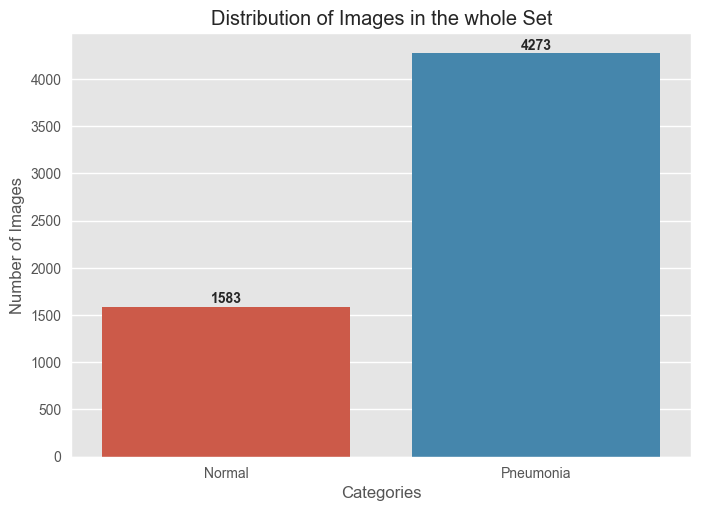

In [65]:
# Plotting the Test subset
plot_normal_pneumonia(normal=normal_test+normal_val+normal_train, 
                      pneumonia=pneumonia_test+pneumonia_val+pneumonia_train)

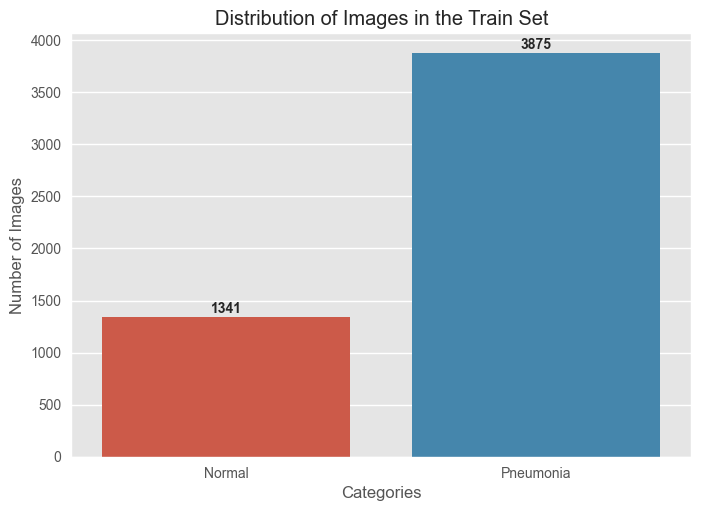

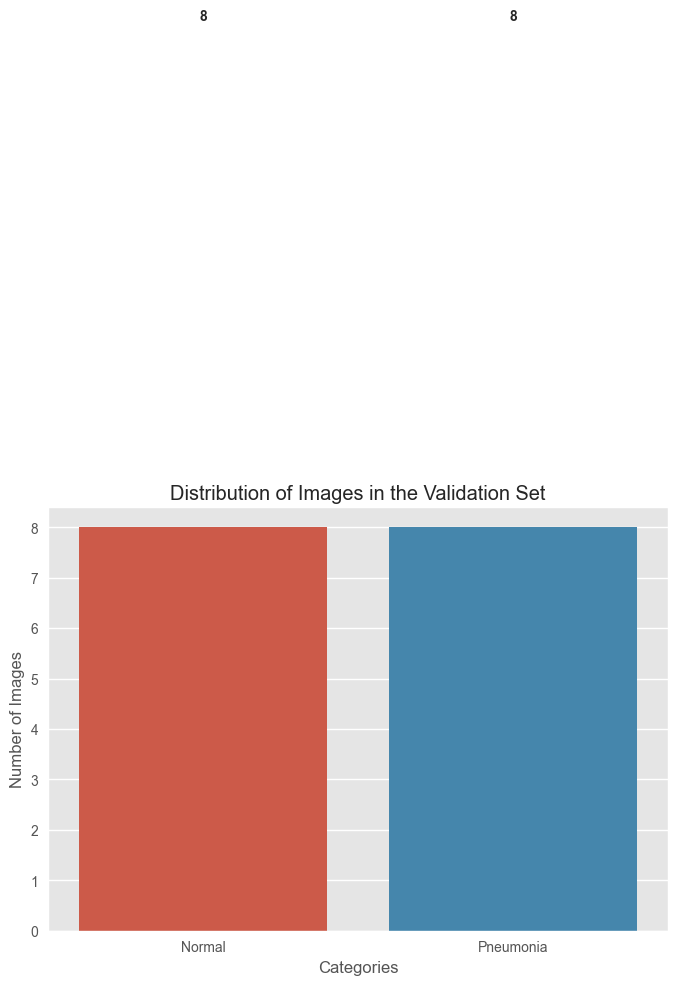

In [67]:
# Plotting the Train subset
plot_normal_pneumonia(normal=normal_train, pneumonia=pneumonia_train, subset="Train")

# Plotting the Validation subset
plot_normal_pneumonia(normal=normal_val, pneumonia=pneumonia_val, subset="Validation")

# Plotting the Test subset
plot_normal_pneumonia(normal=normal_test, pneumonia=pneumonia_test, subset="Test")